In [ ]:
pip install brainspace nilearn brainstat nibabel

In [1]:
from nilearn import datasets, image
import nilearn.plotting as niplot
from nilearn.decomposition import CanICA
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
from brainspace.plotting import plot_hemispheres
from brainstat.datasets import fetch_yeo_networks_metadata
from brainstat.datasets import fetch_parcellation
from brainstat.datasets import fetch_mask, fetch_template_surface
import matplotlib as plt
import numpy as np
from brainspace.mesh.mesh_io import read_surface
import os
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nb
from IPython.display import Image
from nilearn.plotting import plot_prob_atlas
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

# Lab 3 - ICA and PCA for detecting brain networks

In this lab, we are going to explore the brain dynamics via more "traditional" approaches such as independent component analysis (ICA) and principal component analysis (PCA). 

Both approaches are useful to identify the regions that show similar temporal dynamics, in other words, regions that correlate with each other. 

More technically, the earlier approach is looking for seperate components that maximize the explained variance in the given signal, whereas the latter approach is looking for one common component that explains the most variance. 

# ICA

With ICA, we aim to detect the regions that show correlated functional dynamics with eachother. To start with, we are going to download a series of functional images from Nilearn's library. Subjects children changing between 3 and 12 years and are recorded while they are watching a pixar movie (Published [here](https://www.nature.com/articles/s41467-018-03399-2) and available [here](https://nilearn.github.io/stable/modules/generated/nilearn.datasets.fetch_development_fmri.html#footcite-richardson2018). The tutorial is adapted from [here](https://nilearn.github.io/stable/auto_examples/03_connectivity/plot_compare_decomposition.html#sphx-glr-auto-examples-03-connectivity-plot-compare-decomposition-py)).

In [11]:
# First, change to working directiory to Lab folder
os.chdir('path/to/Lab-3_ ICA-and-PCA-for-brain-networks/')

In [12]:
subjects=15 # How many subjects' data we want to download

rest_dataset = datasets.fetch_development_fmri(n_subjects=subjects)
func_filenames = rest_dataset.func  # list of 4D nifti files for each subject

# print basic information on the dataset
print(f"First functional nifti image (4D) is at: {rest_dataset.func[0]}")
mean=image.mean_img(rest_dataset.func[0])

First functional nifti image (4D) is at: /home/koba/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


Let's have a look at a mean image of one subject. Each point on the brain has a time-series with 168 time points. So, each image is a set of time series showing the functional dynamics of that specific point of the brain.

(50, 59, 50, 168)


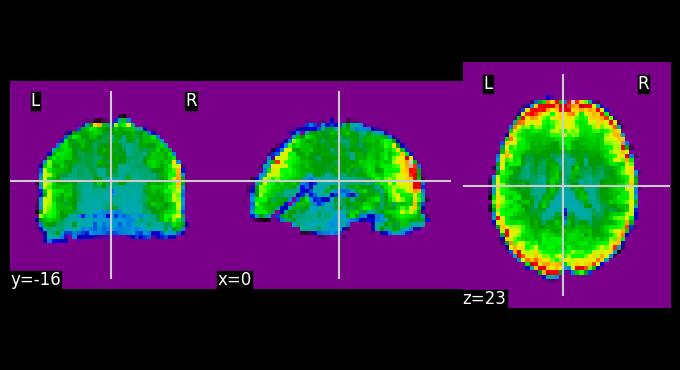

In [13]:
niplot.plot_epi(mean)
print(image.load_img(rest_dataset.func[0]).shape)

# Conducting the ICA 

The detailed method is explained [here](https://pubmed.ncbi.nlm.nih.gov/20153834/). In short, this methods create spatial independent component maps for each subject, and then creates group-level maps based on the spatial consistency of those maps. A snapshot of the workflow can be seen below.

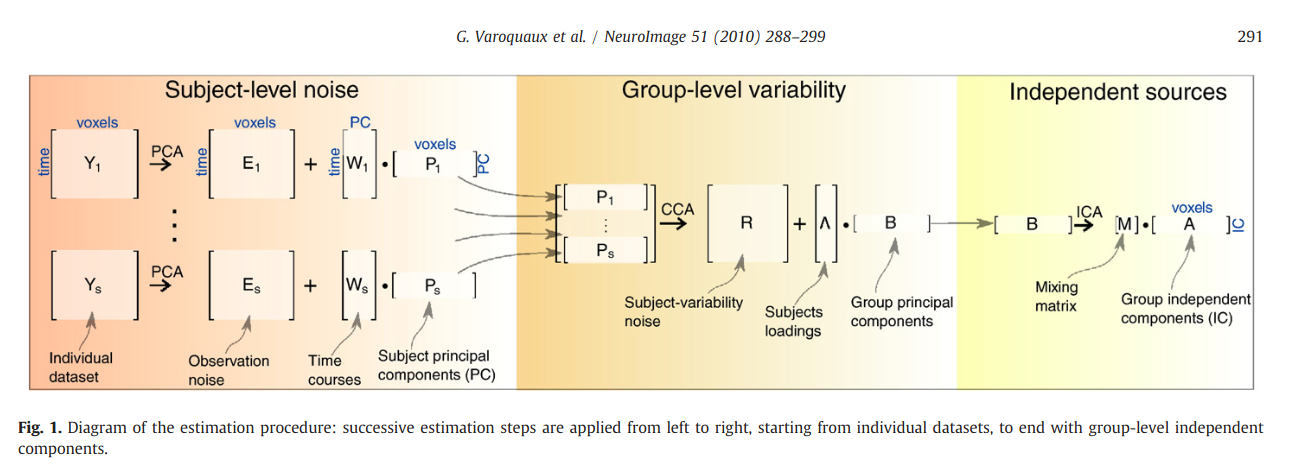

In [14]:
Image(filename='ica_workflow.png') 

In [16]:
# Let's run the model on our data

canica = CanICA(
    n_components=20,
    memory="nilearn_cache",
    memory_level=2,
    verbose=10,
    mask_strategy="whole-brain-template",
    random_state=0,
    standardize="zscore_sample",
)
canica.fit(func_filenames)

# Retrieve the independent components in brain space. Directly
# accessible through attribute `components_img_`.
canica_components_img = canica.components_img_
# components_img is a Nifti Image object, and can be saved to a file with
# the following line:
canica_components_img.to_filename("canica_resting_state.nii.gz")

# Save the component maps seperately
canica_components_img = canica.components_img_

[MultiNiftiMasker.fit] Loading data from [/home/koba/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 /home/koba/nilearn_data/development_fmri/development_fmri/sub-pixar124_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 /home/koba/nilearn_data/development_fmri/development_fmri/sub-pixar125_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 /home/koba/nilearn_data/development_fmri/development_fmri/sub-pixar001_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 /home/koba/nilearn_data/development_fmri/development_fmri/sub-pixar002_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 /home/koba/nilearn_data/development_fmri/development_fmri/sub-pixar003_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 /home/koba/nilearn_data/development_fmri/development_fmri/sub-pixar004_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 /home/koba/ni

/home/koba/.local/lib/python3.10/site-packages/joblib/memory.py:632: UserWarning: Cannot inspect object functools.partial(<function compute_multi_brain_mask at 0x7f9e7a7d2b90>, mask_type='whole-brain'), ignore list will not work.
  return hashing.hash(filter_args(self.func, self.ignore, args, kwargs),


Template whole-brain mask computation


/home/koba/.local/lib/python3.10/site-packages/joblib/memory.py:810: UserWarning: Cannot inspect object functools.partial(<function compute_multi_brain_mask at 0x7f9e7a7d2b90>, mask_type='whole-brain'), ignore list will not work.
  argument_dict = filter_args(self.func, self.ignore,
/home/koba/.local/lib/python3.10/site-packages/joblib/memory.py:632: UserWarning: Cannot inspect object functools.partial(<function compute_multi_brain_mask at 0x7f9e7a7d2b90>, mask_type='whole-brain'), ignore list will not work.
  return hashing.hash(filter_args(self.func, self.ignore, args, kwargs),


[MultiNiftiMasker.transform] Resampling mask
[CanICA] Loading data
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/koba/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/koba/nilearn_data/development_fmri/development_fmri/sub-pixar124_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/koba/nilearn_data/development_fmri/development_fmri/sub

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


__________________________________________________________fastica - 1.4s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.003886, ..., -0.00295 ],
       ...,
       [ 0.005665, ...,  0.001215]]), whiten='arbitrary-variance', fun='cube', random_state=398764591)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


__________________________________________________________fastica - 3.6s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.003886, ..., -0.00295 ],
       ...,
       [ 0.005665, ...,  0.001215]]), whiten='arbitrary-variance', fun='cube', random_state=924231285)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s


__________________________________________________________fastica - 1.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.003886, ..., -0.00295 ],
       ...,
       [ 0.005665, ...,  0.001215]]), whiten='arbitrary-variance', fun='cube', random_state=1478610112)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.7s remaining:    0.0s


__________________________________________________________fastica - 1.2s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.003886, ..., -0.00295 ],
       ...,
       [ 0.005665, ...,  0.001215]]), whiten='arbitrary-variance', fun='cube', random_state=441365315)


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.9s remaining:    0.0s


__________________________________________________________fastica - 1.2s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.003886, ..., -0.00295 ],
       ...,
       [ 0.005665, ...,  0.001215]]), whiten='arbitrary-variance', fun='cube', random_state=1537364731)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.1s remaining:    0.0s


__________________________________________________________fastica - 2.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.003886, ..., -0.00295 ],
       ...,
       [ 0.005665, ...,  0.001215]]), whiten='arbitrary-variance', fun='cube', random_state=192771779)


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   11.1s remaining:    0.0s


__________________________________________________________fastica - 1.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.003886, ..., -0.00295 ],
       ...,
       [ 0.005665, ...,  0.001215]]), whiten='arbitrary-variance', fun='cube', random_state=1491434855)


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   13.0s remaining:    0.0s


__________________________________________________________fastica - 1.2s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.003886, ..., -0.00295 ],
       ...,
       [ 0.005665, ...,  0.001215]]), whiten='arbitrary-variance', fun='cube', random_state=1819583497)


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   14.2s remaining:    0.0s


__________________________________________________________fastica - 1.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[ 0.003886, ..., -0.00295 ],
       ...,
       [ 0.005665, ...,  0.001215]]), whiten='arbitrary-variance', fun='cube', random_state=530702035)


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   16.0s remaining:    0.0s


__________________________________________________________fastica - 3.0s, 0.0min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.0s finished


Plot all ICA components together. All different colors show the regions have similar temporal dynamics
These maps are also known as "networks", so we identified the "brain networks during movie-watching"!

/home/koba/.local/lib/python3.10/site-packages/nilearn/plotting/displays/_axes.py:74: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(
/home/koba/.local/lib/python3.10/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


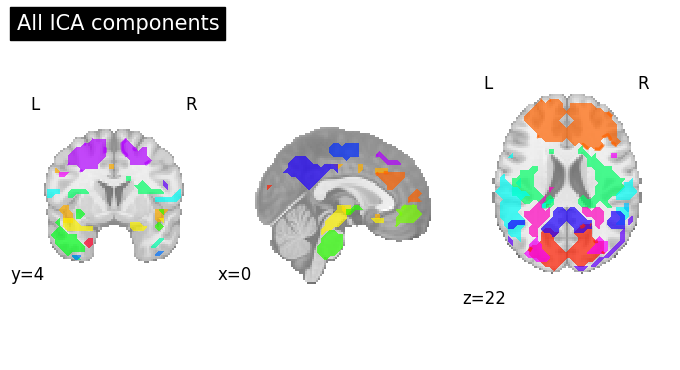

In [17]:
plot_prob_atlas(canica_components_img, title="All ICA components", draw_cross=False)

In [18]:
# 70% of the variance is explained by these networks. This is good!
# The rest can be missing due to factors such as small sample size,
# inconsistincies in the sample, or noise in the data

print('Total explained variance of the brain activity by the identified networks: ', canica.score(canica.components_img_))

[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('canica_resting_state.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.decomposition._base._explained_variance...
_explained_variance(array([[-4.066137e-01, ..., -1.285554e-01],
       ...,
       [-5.443591e-15, ...,  1.395565e-16]]), 
array([[-0., ..., -0.],
       ...,
       [-0., ..., -0.]]), per_component=False)
_______________________________________________explained_variance - 0.1s, 0.0min
Total explained variance of the brain activity by the identified networks:  0.6999648555553564


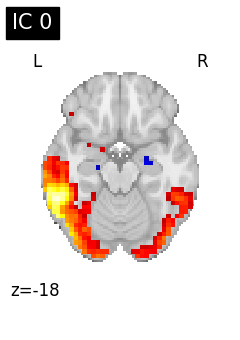

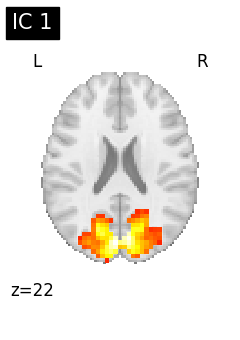

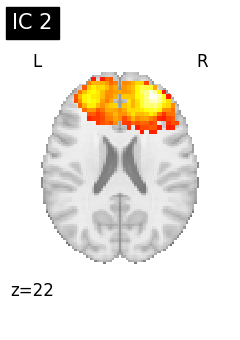

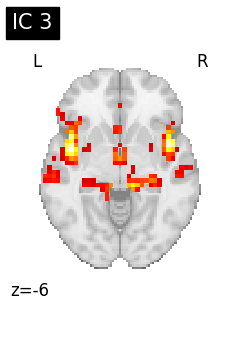

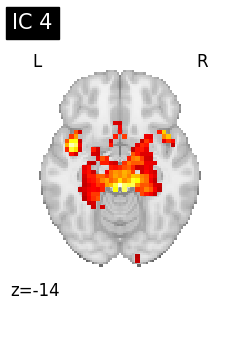

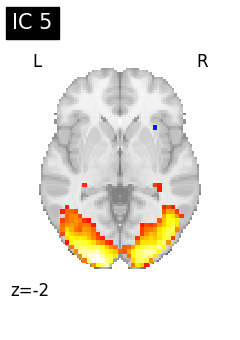

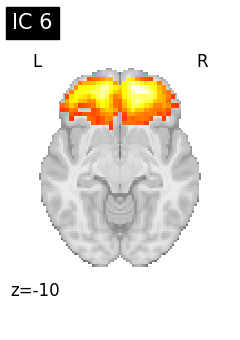

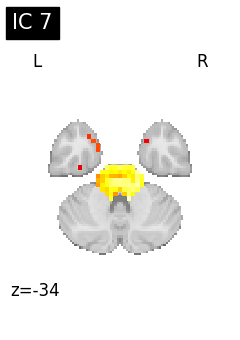

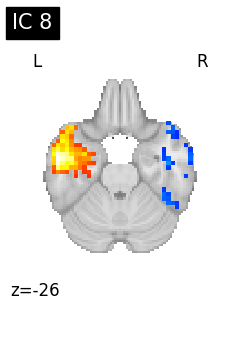

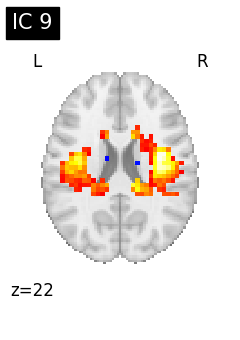

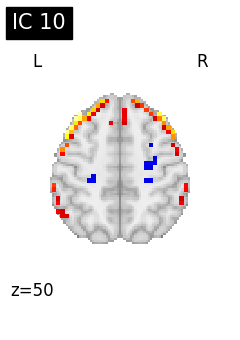

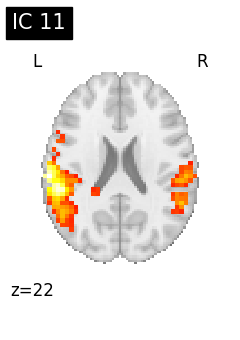

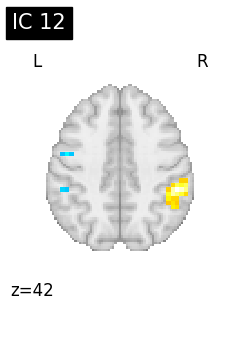

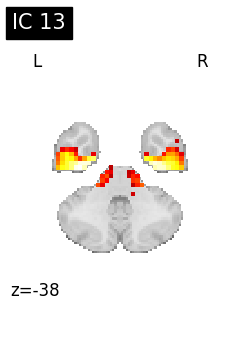

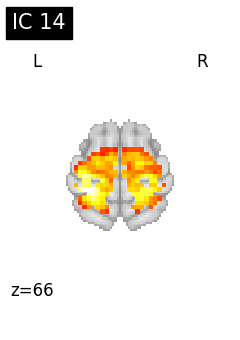

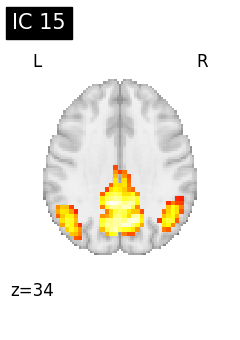

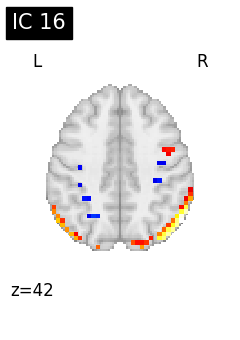

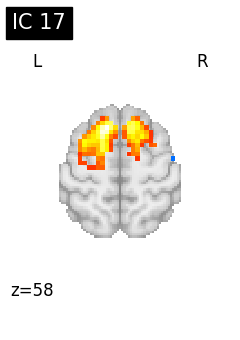

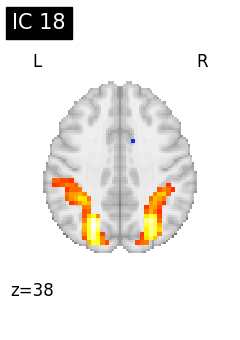

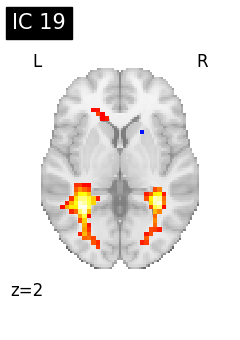

In [19]:
# Let's check them one by one 

for i, cur_img in enumerate(iter_img(canica_components_img)):
    plot_stat_map(
        cur_img,
        display_mode="z",
        title=f"IC {int(i)}",
        cut_coords=1,
        colorbar=False,
    )

### Okay, they look nice, but what do these maps show? 

Now we detected the networks, but we do not know what function or feature they are associated with. Luckily, there is a tool that excels at "decoding" brain maps into their associated structure or functions, called [NeuroSynth](https://neurosynth.org/). It basically utilizes the association between the brain coordinates and cognitive functions reported in (a lot of) previous studes, so it is a kind of meta-search. The tool is capable of doing much more, go ahead and play with it! 

In our specific case, we upload those network maps into a NeuroVault [repository](https://neurovault.org/collections/15707/), and then use NeuroSynth's decode function there: 

P.s.: There is a nicer way to do the same via python code using neurosynth api and create beatiful wordclouds,  but for some reason it tells me "it is deprecated". 

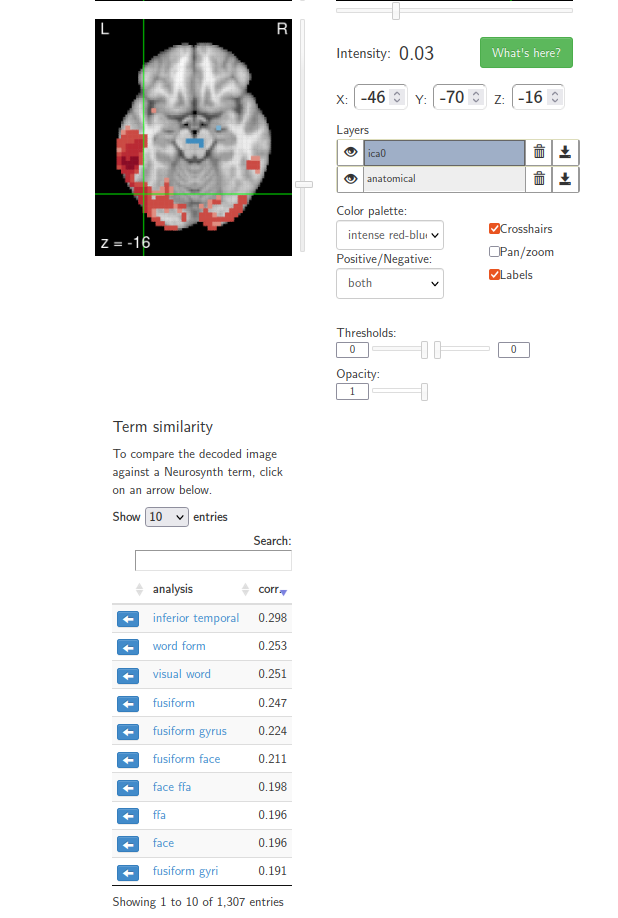

In [5]:
Image(filename='ica.png') 

### Now I know what my IC-generated networks mean. How is that useful? 

ICA is a common method to detect brain networks and it has high reproducibility. The consistency of the similar networks were shown many times in the literature. Therefore, it is possible to the check the spatial distribution of the specific networks are different in special populations (e.g. visual network in blind people,), or in specific conditions (e.g. attention network during resting vs. during movie watching). 

# PCA

In order to apply PCA on our data, we are going to follow the method in [Marguiles's paper](https://www.pnas.org/doi/10.1073/pnas.1608282113). This method allows decreasing the dimension of the brain signal into a very small number (1-3), and summarize the brain function-structure with nice visualization. However, instead of applying PCA on the data directly (like ICA), this method defines the functionally similar regions first. This helps us to see the regions that are close to each other:




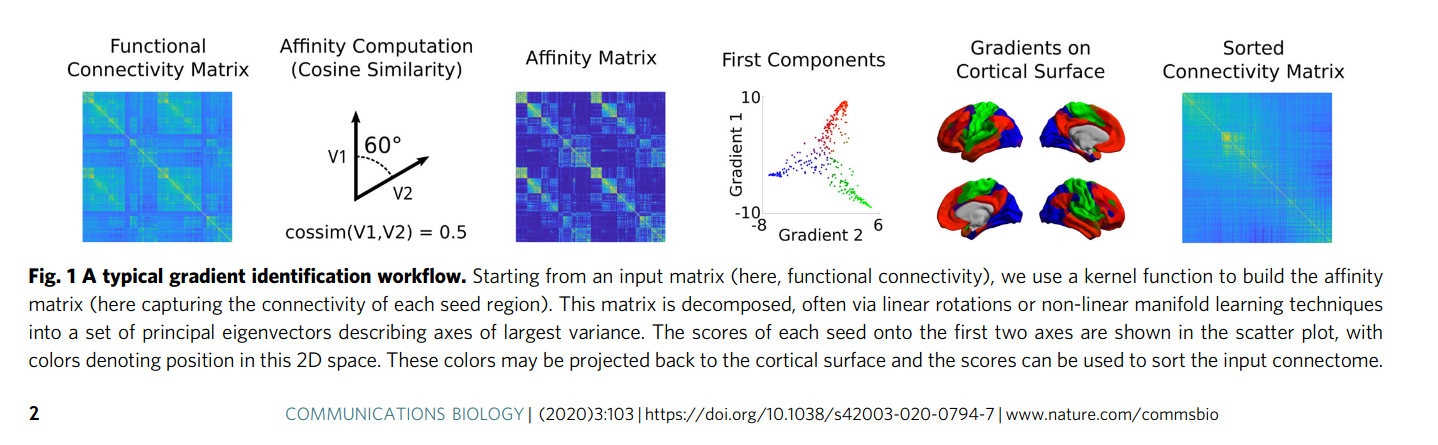

In [20]:
Image('pca.png')

The following steps are a combination of the [BrainSpace](https://brainspace.readthedocs.io/en/latest/) ([relevant paper, more methods-rich](https://doi.org/10.1038/s42003-020-0794-7)), [BrainStat](https://brainstat.readthedocs.io/en/master/), and [Micapipe](https://micapipe.readthedocs.io/en/latest/) toolboxes. The procedure described in the Marguiles's paper is applied via BrainSpace, and the other two toolboxes are mostly used for visualization. This method is mostly applied on the "surface space" rather than "voxel space", so the existing toolboxes adopted this tradition. This is why the visuals will be a bit different compared to ICA, 

In [21]:
# Prepare the surface meshes. This code block is for preaparing the upcoming figures

labeling_conte = load_parcellation('schaefer', scale=400, join=True)
c69_lh, c69_rh = load_conte69()


# Load fsaverage5
fs5_lh = read_surface('lh.pial', itype='fs')
fs5_rh = read_surface('rh.pial', itype='fs')


# Load annotation file in fsaverage5
annot_lh_fs5= nb.freesurfer.read_annot('lh.Schaefer2018_400Parcels_7Networks_order.annot')
annot_rh_fs5= nb.freesurfer.read_annot('rh.Schaefer2018_400Parcels_7Networks_order.annot')[0]+200

# replace with 0 the medial wall of the right labels
annot_rh_fs5 = np.where(annot_rh_fs5==200, 0, annot_rh_fs5)

# fsaverage5 labels
labels_fs5 = np.concatenate((annot_lh_fs5[0], annot_rh_fs5), axis=0)

The data we are going to use is a set of resting-state data from [HCP dataset](https://www.humanconnectome.org/study/hcp-young-adult/data-releases), available in BrainSpace's library. It contains the brain activity during when the subject do not do anything particular, hence measuring natural dynamics of the brain. However, before PCA is applied, the data is already reduced to 400 hundred regions by using the parcellation below. Mean time series within the voxels that corresponding the same regions were extracted, and averaged across subjects: 

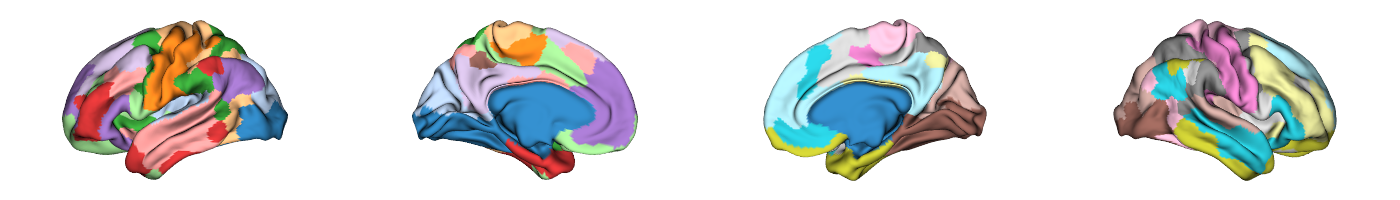

In [22]:
yeo_networks = fetch_parcellation("fsaverage5", "yeo", 7)
network_names, yeo_colormap = fetch_yeo_networks_metadata(7)

plot_hemispheres(
    c69_lh,
    c69_rh,
    labeling_conte,
    embed_nb=True,
    cmap="tab20",
    nan_color=(0.7, 0.7, 0.7, 1),
    size=(1400, 200),
    zoom=1.45,
)

Then, each time series were correlated with each other, creating a 400x400 correlation matrix. As can be seen, some regions have high correlation and already form some clusters that is visible to naked eye:

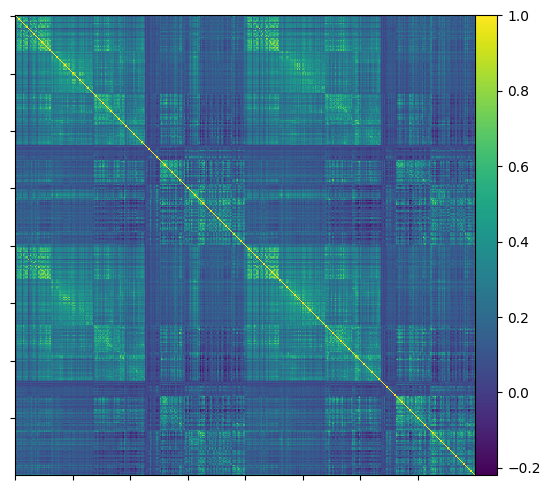

In [23]:
conn_matrix = load_group_fc('schaefer', scale=400)
niplot.plot_matrix(conn_matrix, cmap='viridis')

With the following simple line of code, we are going to calculate the affinity matrix and apply PCA on the thresholded affinity matrix. This will return the 10 principal components, and their eigenvalues (explained variances). 

In [24]:
gm = GradientMaps(n_components=10, approach="pca")
gm.fit(conn_matrix, sparsity=0.8)

GradientMaps(approach='pca')

In the plot below, you can see the eigenvalues of the components. The first 3 principal components have the highest eigenvalues, hence they explain the most variances in the affinity matrices. 

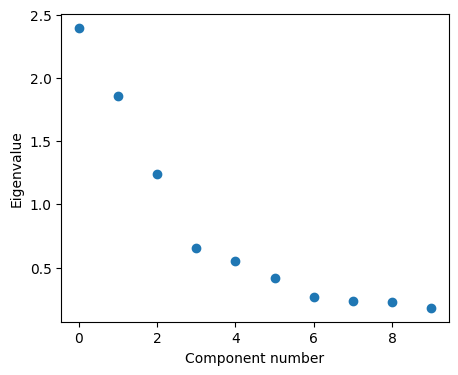

In [25]:
fig, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(gm.lambdas_.size), gm.lambdas_)
ax.set_xlabel('Component number')
ax.set_ylabel('Eigenvalue')

plt.show()

Let's look the distribution of the principal component values over regions 

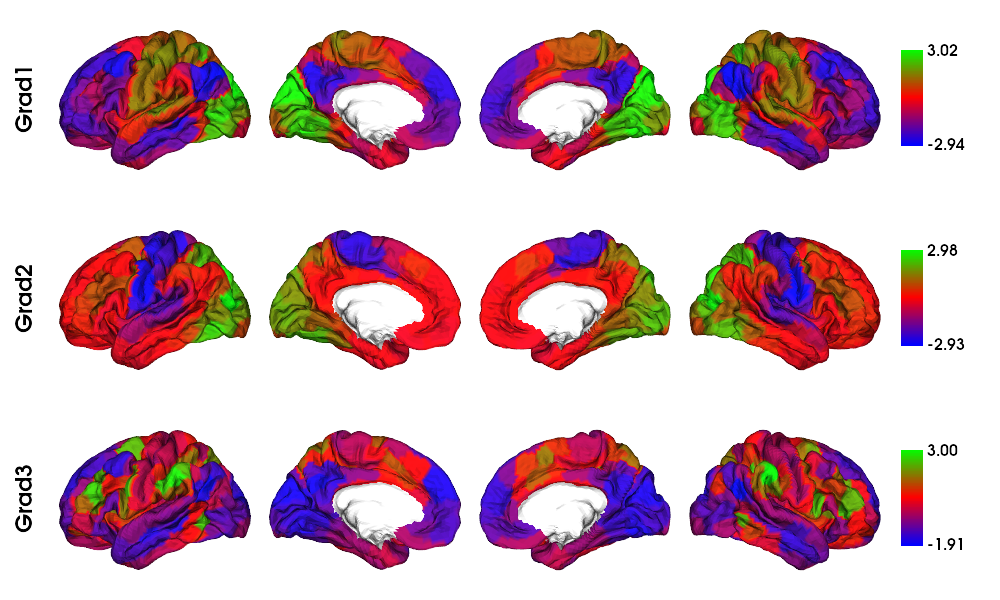

In [26]:
# Mask of the medial wall on fsaverage 5
mask_fs5 = labels_fs5 != 0

 # Map gradients to original parcels
grad = [None] * 3

for i, g in enumerate(gm.gradients_.T[0:3,:]):
     grad[i] = map_to_labels(g, labels_fs5,  fill=np.nan, mask=mask_fs5)

 # Plot Gradients RdYlBu
plot_hemispheres(fs5_lh, fs5_rh, array_name=grad, size=(1000, 600), cmap='brg',
                  embed_nb=True,  label_text={'left':['Grad1', 'Grad2','Grad3']}, color_bar='right',
                  zoom=1.25, nan_color=(1, 1, 1, 1) )

### Cool. But what am I looking at? 

Let's focus on the first principal component, "Grad1". If you look at the colorbar, you will see that the lowest values are coded with blue, and the highest values are coded with green. The interpretation of this method is that brain function is organized in this "color-axis". Regions that are on the extreme of this distribution are functionally similar to each other, and most of the brain function can be explained by the commonalities of these regions. You can see the distribution of the regions in the 2D space in the following figure:

Text(0, 0.5, 'PCA loadings of Gradient 2')

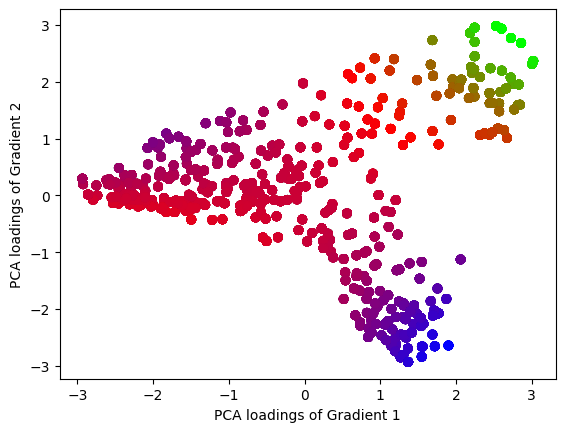

In [27]:
plt.scatter(np.array(grad)[0,:],np.array(grad)[1,:],c=(np.array(grad)[0,:]*np.array(grad)[1,:]),cmap='brg')
plt.xlabel('PCA loadings of Gradient 1')
plt.ylabel('PCA loadings of Gradient 2')

### What do these "similar regions" correspond to?

We will apply a decoding approach similar to the ICA maps. First, we are going to retrieve a an atlas of 7 functional connectivity network (previously defined by ICA!), and check which which PC loadings correspond to which networks. 

The network atlas is displayed below:

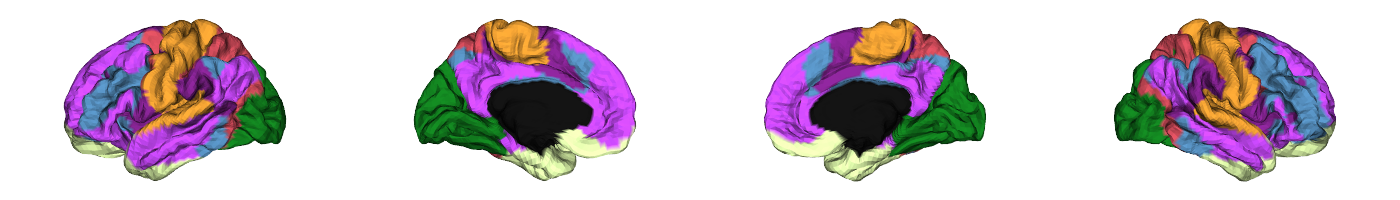

In [28]:
surfaces = fetch_template_surface("fsaverage5", join=False)
yeo_networks = fetch_parcellation("fsaverage5", "yeo", 7)
network_names, yeo_colormap = fetch_yeo_networks_metadata(7)

plot_hemispheres(
    surfaces[0],
    surfaces[1],
    yeo_networks,
    embed_nb=True,
    cmap="yeo7",
    nan_color=(0.7, 0.7, 0.7, 1),
    size=(1400, 200),
    zoom=1.45,
)

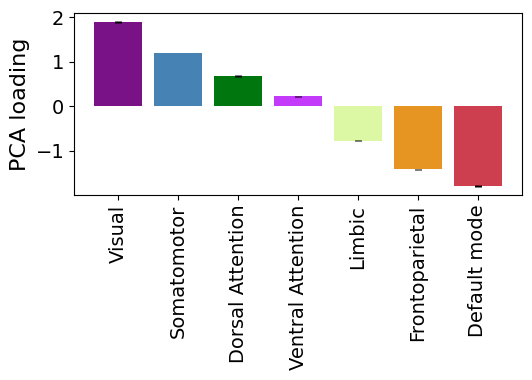

In [29]:
import matplotlib.pyplot as plt
from scipy.stats import sem

from brainstat.context.resting import yeo_networks_associations

yeo_tstat_mean = yeo_networks_associations(grad[0], "fsaverage5")
yeo_tstat_sem = yeo_networks_associations(
    grad[0],
    "fsaverage5",
    reduction_operation=lambda x, y: sem(x, nan_policy="omit"),
)

plt.bar(
    np.arange(7),
    yeo_tstat_mean[:, 0],
    yerr=yeo_tstat_sem.flatten(),
    color=yeo_colormap,
    error_kw={"elinewidth": 5},
)
plt.xticks(np.arange(7), network_names, rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("PCA loading", fontdict={"fontsize": 16})
plt.gcf().subplots_adjust(left=0.2, bottom=0.5)
plt.show()

### What does it mean? 

In the above figure, you can see the quantification of the PC scores within the 7 networks we downloaded. As you can see, for the first PC, the visual and somatomotor networks have the highest concentration, and the default/frontoparietal networks have the lowest concentration. This implies that, brain function is mostly organized in the basic functions vs. higher functions axis. regions that are related to those basic cognitive functions are form a cluster, whereas the regions that are related to complex cognitive functions form another one. 

Can you edit the code and check the function distribution of the second and third gradients? 

### Take-home message

Reltively simpler approaches such as ICA and PCA are still very suitable to examine the brain dynamics. They can lead to very complex analysis and are highly reproducible. Identify your needs depending on your hypothesis, and do not unnecessarily complicate your analysis pipeline. 